In [1]:
# Numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Dataset
import keras.datasets as ds

# Unconditional GAN
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, BatchNormalization, UpSampling2D

# Conditional GAN
from keras.models import Model
from keras.layers import Input, Embedding, Concatenate

# Visualization tools
from IPython.display import clear_output, Image
import time

Using TensorFlow backend.


In [2]:
# Load selected dataset
def load_dataset(dataset):

    if dataset == 'MNIST':
        (trainX, trainy), (_, _) = ds.mnist.load_data()

    if dataset == 'Fashion-MNIST':
        (trainX, trainy), (_, _) = ds.fashion_mnist.load_data()

    # Exapnd to 3D adding one channel
    X = np.expand_dims(trainX, axis=-1)

    # Convert from int to float and rescale from [0, 255] to [-1, 1]
    X = X.astype('float32')
    X = (X - (255 / 2)) / (255 / 2)
    #X = X / 255.
    return [X, trainy]



# Build Discriminator
def build_discriminator(input_shape):

    # Initialize the NN
    model = Sequential()

    # First convolutional layer
    model.add(Conv2D(128, 3, strides=2, padding='same', input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))

    # Second convolutional layer
    model.add(Conv2D(256, 3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    
    # Second convolutional layer
    model.add(Conv2D(512, 3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))

    # Flattening and output layer
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model



# Build Generator with default latent_space=100
def build_generator(latent_dim=100):

    # Initialize the NN
    model = Sequential()

    # Fully connected layer
    model.add(Dense(7 * 7 * 512, input_dim=latent_dim))
    model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 512)))
    model.add(Dropout(0.4))

    # First upsampling layer 14x14
    model.add(UpSampling2D())
    model.add(Conv2D(256, 3, padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU(alpha=0.2))
    
    # Second upsampling layer 28x28
    model.add(UpSampling2D())
    model.add(Conv2D(128, 3, padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU(alpha=0.2))
    
    # Second upsampling layer 28x28
    model.add(Conv2D(64, 3, padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU(alpha=0.2))
    
    # Output layer
    model.add(Conv2D(1, 3, activation='tanh', padding='same'))
    return model



# Build the GAN framework
def build_gan(D, G, input_shape, latent_dim):

    opt = Adam(lr=0.0002, beta_1=0.5)

    # Freeze discriminator weights during generator training
    D.trainable = False
    #D.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    # Connect generator and discriminator
    GAN = Sequential()
    GAN.add(G)
    GAN.add(D)
    GAN.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return GAN

In [3]:
def gen_real(dataset, batch_size):
    X = dataset[np.random.randint(0, dataset.shape[0], size=batch_size), :, :, :]
    y = np.ones((batch_size, 1))
    return X, y


def gen_fake(G, latent_dim, batch_size):
    z = np.random.randn(latent_dim * batch_size)
    z = z.reshape(batch_size, latent_dim)
    X = G.predict(z)
    y = np.zeros((batch_size, 1))
    return X, y


# Train the GAN
def train(D, G, GAN, dataset, latent_dim=100, epochs=20, batch_size=128):
    
    batch_per_epoch = int(dataset.shape[0] / batch_size)
    half_batch = int(batch_size / 2)
    
    D_loss = []
    D_acc = []
    G_loss = []
    G_acc = []
    
    etime = []
    

    # Loop over epochs
    for epoch in range(epochs):
        
        start_t = time.time()
        
        eD_loss = []
        eD_acc = []
        eG_loss = []
        eG_acc = []
        
        for mbatch in range(batch_per_epoch):

            # Random select half_batch real samples
            realX, realY = gen_real(dataset, half_batch)
            
            # Random generate half_batch fake samples
            fakeX, fakeY = gen_fake(G, latent_dim, half_batch)

            # Stacks all samples together and train the discriminator
            X, y = np.vstack((realX, fakeX)), np.vstack((realY, fakeY))
            D_stats = D.train_on_batch(X, y)
            
            # Generate random noise and labels to train the Generator
            Z_gan = np.random.randn(latent_dim * batch_size).reshape(batch_size, latent_dim)
            y_gan = np.ones((batch_size, 1))
            G_stats = GAN.train_on_batch(Z_gan, y_gan)
            
            # Save batch parameters
            eD_loss.append(D_stats[0])
            eD_acc.append(D_stats[1])
            eG_loss.append(G_stats[0])
            eG_acc.append(G_stats[1])
        
        end_t = time.time()
        
        # Save all
        D_loss.append(eD_loss)
        D_acc.append(eD_acc)
        G_loss.append(eG_loss)
        G_acc.append(eG_acc)
        etime.append(end_t - start_t)
        
        # Print epoch mean value
        print('Epoch-%d: dl=%.3f gl=%.3f da=%.3f ga=%.3f time=%f' %(epoch, np.mean(eD_loss), np.mean(eG_loss), np.mean(eD_acc), np.mean(eG_acc), (etime[epoch])))

    return D_loss, D_acc, G_loss, G_acc

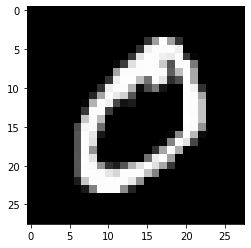

(28, 28, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 128)       1280      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 256)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 

C:\Users\Ax09\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [4]:
# Load dataset
trainX, trainy = load_dataset('MNIST')

plt.figure()
img = np.reshape(trainX[1], [28, 28])
plt.imshow(img, cmap='gray')
plt.show()

# Define latent space
latent_space = 100
in_shape = (trainX[0].shape[0], trainX[0].shape[1], 1)

print(in_shape)

# Build Generator and Discriminator
D = build_discriminator(input_shape=in_shape)
G = build_generator(latent_dim=latent_space)

# Create DCGAN framework
GAN = build_gan(D, G, in_shape, latent_space)

D.summary()
# Train DCGAN
#D_l, D_a, G_l, G_a = train(D, G, GAN, trainX)

In [5]:
G.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 25088)             2533888   
_________________________________________________________________
batch_normalization_1 (Batch (None, 25088)             100352    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 25088)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 512)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 512)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 512)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 256)      

In [6]:
GAN.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 28, 28, 1)         4185345   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1484801   
Total params: 5,670,146
Trainable params: 4,134,273
Non-trainable params: 1,535,873
_________________________________________________________________


In [7]:
# Train DCGAN
D_l, D_a, G_l, G_a = train(D, G, GAN, trainX, latent_dim=latent_space)

C:\Users\Ax09\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch-0: dl=0.623 gl=0.646 da=0.574 ga=0.505 time=71.220645
Epoch-1: dl=0.690 gl=0.716 da=0.532 ga=0.391 time=65.535839
Epoch-2: dl=0.687 gl=0.719 da=0.547 ga=0.397 time=65.421155
Epoch-3: dl=0.685 gl=0.726 da=0.554 ga=0.389 time=65.423038
Epoch-4: dl=0.682 gl=0.734 da=0.562 ga=0.386 time=65.413205
Epoch-5: dl=0.681 gl=0.739 da=0.562 ga=0.391 time=65.430457
Epoch-6: dl=0.679 gl=0.746 da=0.569 ga=0.387 time=65.434224
Epoch-7: dl=0.677 gl=0.752 da=0.573 ga=0.392 time=65.452422
Epoch-8: dl=0.675 gl=0.763 da=0.576 ga=0.379 time=65.399643
Epoch-9: dl=0.674 gl=0.760 da=0.576 ga=0.391 time=65.411347
Epoch-10: dl=0.673 gl=0.764 da=0.581 ga=0.384 time=65.437636
Epoch-11: dl=0.673 gl=0.766 da=0.583 ga=0.390 time=65.417270
Epoch-12: dl=0.673 gl=0.767 da=0.580 ga=0.389 time=65.400927
Epoch-13: dl=0.672 gl=0.770 da=0.582 ga=0.385 time=65.842083
Epoch-14: dl=0.671 gl=0.771 da=0.583 ga=0.393 time=65.445494
Epoch-15: dl=0.672 gl=0.769 da=0.583 ga=0.391 time=65.414110
Epoch-16: dl=0.671 gl=0.773 da=0.5

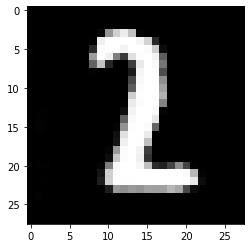

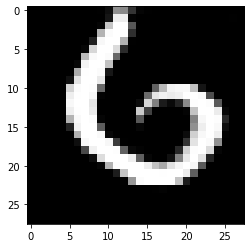

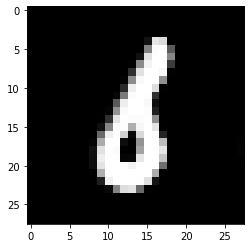

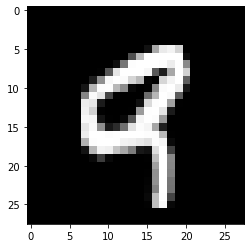

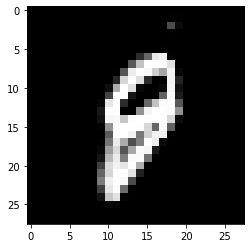

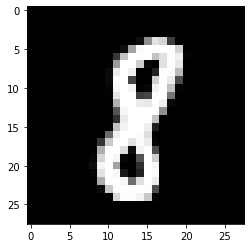

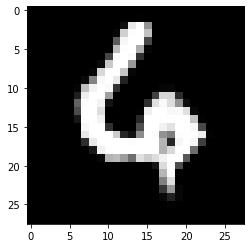

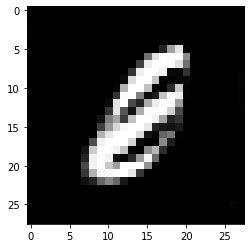

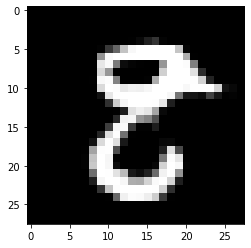

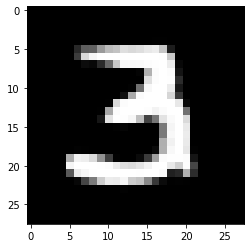

In [8]:
for i in range(10):
    tmp_z = np.random.randn(latent_space).reshape(1,latent_space)

    gen = G.predict(tmp_z)
    
    plt.figure()
    img = np.reshape(gen, [28, 28])
    plt.imshow(img, cmap='gray')
    plt.show()

    #plt.imshow(gen[0, :, :, 0], cmap='grey')
    #plt.show()

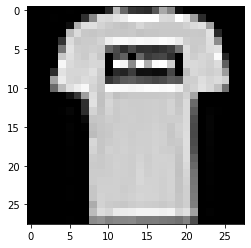

Shape: (28, 28, 1)


C:\Users\Ax09\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch-0: dl=0.660 gl=0.625 da=0.546 ga=0.557 time=69.101049
Epoch-1: dl=0.671 gl=0.731 da=0.591 ga=0.374 time=65.502671
Epoch-2: dl=0.672 gl=0.760 da=0.585 ga=0.358 time=65.453569
Epoch-3: dl=0.652 gl=0.778 da=0.616 ga=0.370 time=65.483100
Epoch-4: dl=0.660 gl=0.790 da=0.605 ga=0.354 time=65.475641
Epoch-5: dl=0.667 gl=0.783 da=0.592 ga=0.343 time=65.479199
Epoch-6: dl=0.663 gl=0.787 da=0.601 ga=0.357 time=65.465931
Epoch-7: dl=0.659 gl=0.796 da=0.608 ga=0.356 time=65.497054
Epoch-8: dl=0.665 gl=0.785 da=0.592 ga=0.359 time=66.147664
Epoch-9: dl=0.670 gl=0.781 da=0.585 ga=0.350 time=65.849646
Epoch-10: dl=0.669 gl=0.781 da=0.585 ga=0.351 time=66.176798
Epoch-11: dl=0.668 gl=0.779 da=0.589 ga=0.362 time=65.665051
Epoch-12: dl=0.666 gl=0.791 da=0.594 ga=0.346 time=65.527933
Epoch-13: dl=0.667 gl=0.786 da=0.588 ga=0.357 time=65.496222
Epoch-14: dl=0.670 gl=0.785 da=0.585 ga=0.348 time=68.522987
Epoch-15: dl=0.668 gl=0.790 da=0.588 ga=0.344 time=67.588303
Epoch-16: dl=0.669 gl=0.788 da=0.5

In [9]:
# Test on fashion-mist
# Load dataset
fashion_mnist, _ = load_dataset('Fashion-MNIST')

# Plot dataset element
plt.figure()
img = np.reshape(fashion_mnist[1], [28, 28])
plt.imshow(img, cmap='gray')
plt.show()

# Define latent space
latent_space = 100
in_shape = (fashion_mnist[0].shape[0], fashion_mnist[0].shape[1], 1)

print('Shape:', in_shape)

# Build Generator and Discriminator
D_f = build_discriminator(input_shape=in_shape)
G_f = build_generator(latent_dim=latent_space)

# Create DCGAN framework
GAN_f = build_gan(D_f, G_f, in_shape, latent_space)

# Train DCGAN
Df_l, Df_a, Gf_l, Gf_a = train(D_f, G_f, GAN_f, fashion_mnist, latent_dim=latent_space)


[[0.57945824]]


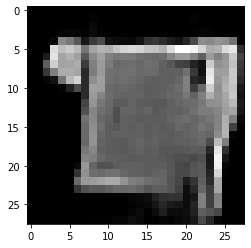

[[0.4571413]]


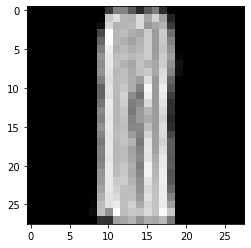

[[0.49060157]]


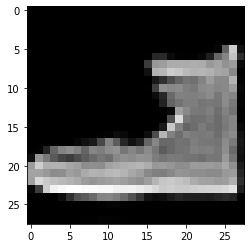

[[0.3568829]]


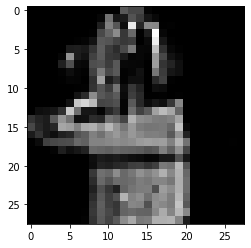

[[0.60580534]]


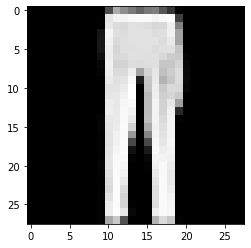

[[0.4143003]]


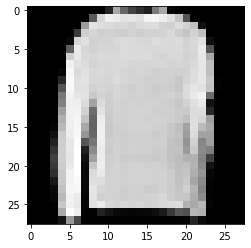

[[0.5558281]]


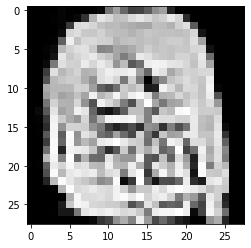

[[0.3435298]]


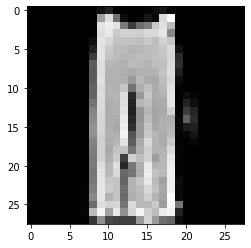

[[0.4665239]]


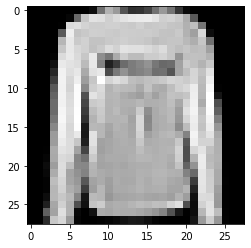

[[0.47590944]]


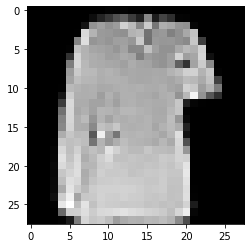

In [13]:
test = []

for i in range(10):
    tmp_z = np.random.randn(latent_space).reshape(1,latent_space)

    gen = G_f.predict(tmp_z)
    test.append(D_f.predict(gen))
    print(test[i])
    plt.figure()
    img = np.reshape(gen, [28, 28])
    plt.imshow(img, cmap='gray')
    plt.show()
    


9360


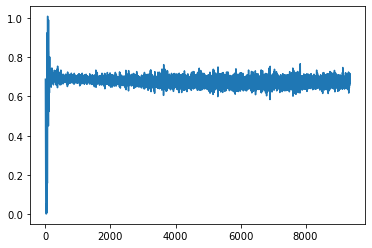

In [11]:
D_l = np.reshape(D_l, [len(D_l) * len(D_l[0])])
print(len(D_l))

plt.figure()
plt.plot(D_l)
plt.show()

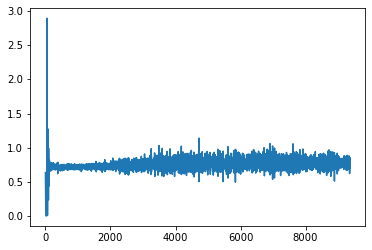

In [12]:
G_l = np.reshape(G_l, [len(G_l) * len(G_l[0])])
plt.figure()
plt.plot(G_l)
plt.show()
